# Implementing the SIFT algorithm with OpenCV basic functions
Author: Huy Nguyen (40090345)
GitHub: https://github.com/giahuy22012000/ImplementingSIFT

In this project, we attempt reimplement the famous Scale Invariant Feature Tranform algorithm to better understand how it works under the hood. The challenge is to complete the task using only OpenCV basic functions including:
```
imRead, resize, GaussianBlur, Sobel
```

In the second part of this project, we use the implemented algorithm to solve a simple task - retrieve the original image file from a print of it.

In [226]:
# import libraries
import cv2 as cv
import matplotlib.pyplot as plt
import PIL
import math
import numpy as np
from collections import namedtuple

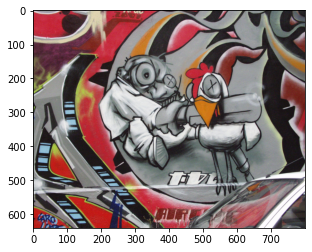

In [227]:
# read the image
image = cv.imread('data/graf1.png')
# cv2 by default read images as BGR
image_rgb = cv.cvtColor(image,cv.COLOR_BGR2RGB)
# display it
plt.imshow(image_rgb)

# Procedure
SIFT operator consists of 4 steps:
- Scale-space extrema detection
- Keypoint localization
- Orientation assignment
- Keypoint descriptor

In [228]:
# some constants
K = math.sqrt(2)
sigma = 1.6
kernel_size = 3
num_scales = 5
num_octave = 4


In [229]:
# basic functions


def gaussian_blur(image, sigma):
    # print(sigma)
    return cv.GaussianBlur(image, (kernel_size, kernel_size), sigma)


def downsample(image, factor=2):
    (rows, cols) = image.shape
    return cv.resize(image, (cols // 2, rows // 2))


In [230]:
def computeOctave(img, num_scales, sigma=1.6):
    # convolve image with different scale of gaussian
    out = []
    for i in range(num_scales):
        img_blur = gaussian_blur(img, sigma)
        out.append(img_blur)
        sigma *= K
    return out


def differentiateOctave(octave):
    # compute Difference of Gaussian
    out = []
    for i in range(len(octave)):
        if i != 0:
            img_DoG = octave[i] - octave[i - 1]
            out.append(img_DoG)
    return out


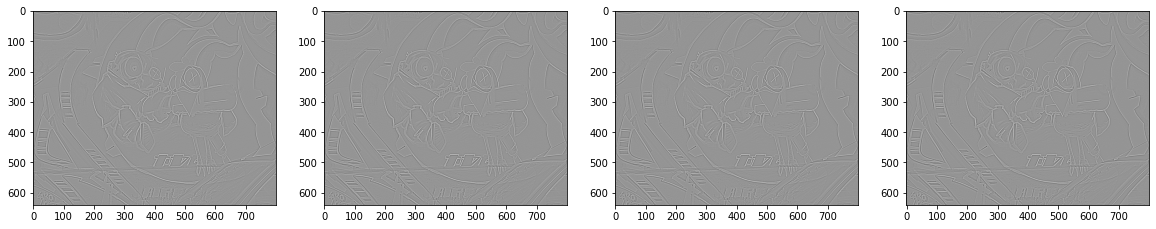

In [231]:
img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
img_float = img_gray.astype(np.float32) / 256

octave = computeOctave(img_float, num_scales, sigma)
octave = differentiateOctave(octave)

# display DoG
plt.figure(figsize=(20, 10))
for i in range(len(octave)):
    plt.subplot(1, num_scales - 1, i + 1)
    plt.imshow(octave[i], cmap="Greys_r")


## 1. Detect extrema with DoG
In this first step, the input image is convoluted with a sequence of Gaussian kernel with increasing $\sigma$ values. The result images are then used to approximate Laplacian of Gaussian (LoG) by calculating Difference of Gaussian (DoG).

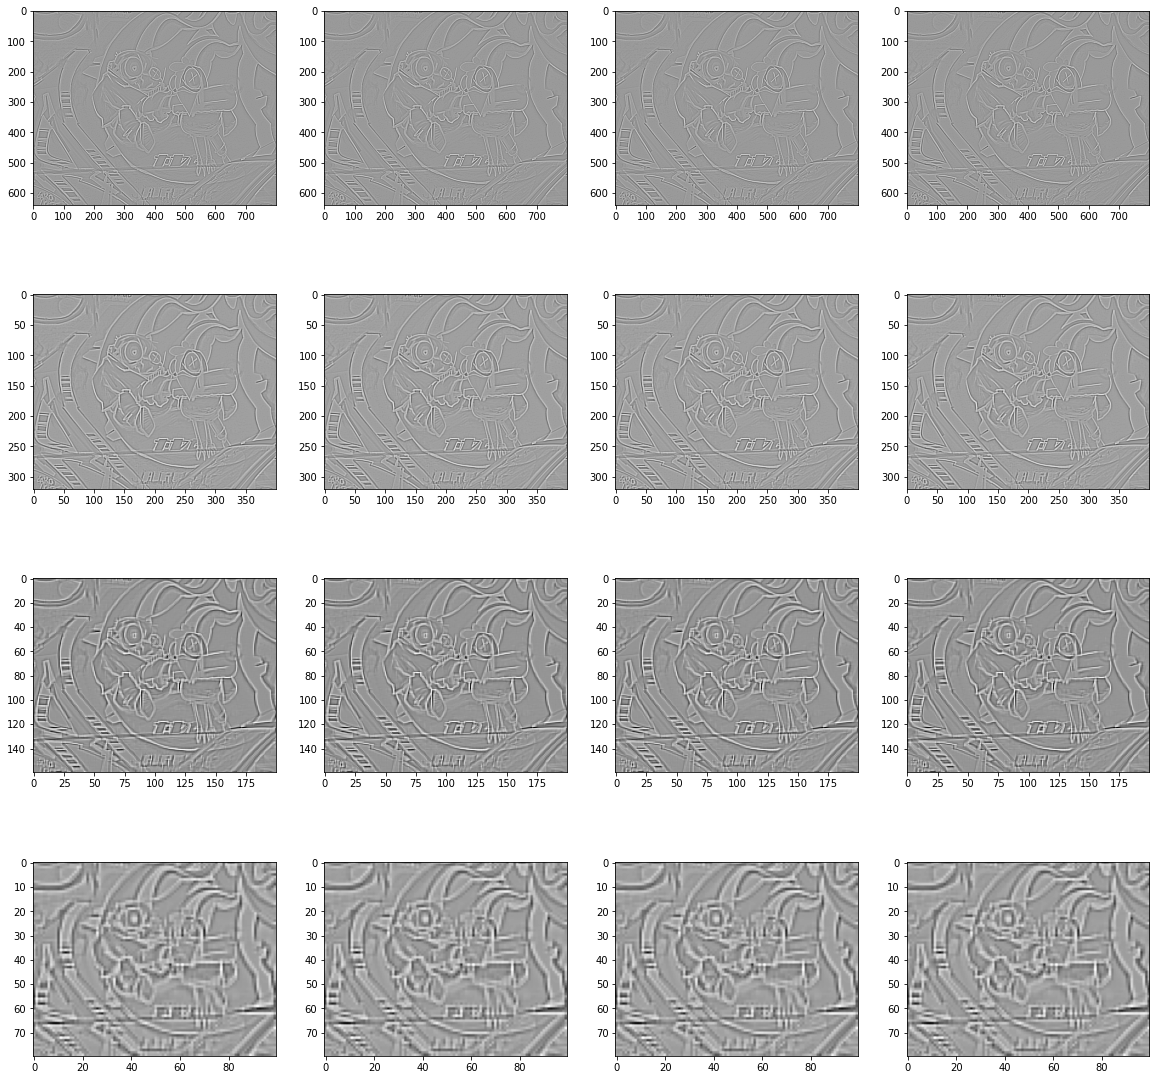

In [232]:

def detectExtrema(image):
    # compute Difference of Gaussian
    img_blur = gaussian_blur(image, sigma)
    octaves_DoG = []
    img_half = np.copy(img_blur)
    for i in range(num_octave):
        octave = computeOctave(img_half, num_scales, sigma * (i + 1))
        DoG = differentiateOctave(octave)
        octaves_DoG.append(DoG)
        img_half = downsample(img_half, 2)
    return octaves_DoG

# 
octaves_DoG = detectExtrema(img_float)
plt.figure(figsize=(20, 20))
for i in range(num_octave):
    for j in range(num_scales-1):
        plt.subplot(num_octave, num_scales - 1, i*(num_scales-1)+j+1)
        plt.imshow(octaves_DoG[i][j], cmap="Greys_r")



In [233]:
KeyPoint = namedtuple("KeyPoint", "x y ")


def locateKeypoints(octaves_DoG):
    # locate extrema in scale-space 3x3x3 neighborhood
    kps = []
    map = np.zeros_like(octaves_DoG[0][0])
    for i in range(num_octave):
        for j in range(1, num_scales - 2):
            print(i, j)
            DoG_prev = octaves_DoG[i][j - 1]
            DoG_next = octaves_DoG[i][j + 1]
            DoG = octaves_DoG[i][j]
            (nrows, ncols) = DoG.shape
            for y in range(1, nrows - 1):
                for x in range(1, ncols - 1):
                    # skip if this is already marked as a keypoint
                    if map[y, x] == 0:
                        # 26 neighbor values
                        neighbors = np.array(
                            [
                                DoG_prev[y - 1, x - 1],
                                DoG_prev[y - 1, x],
                                DoG_prev[y - 1, x + 1],
                                DoG_prev[y, x - 1],
                                DoG_prev[y, x],
                                DoG_prev[y, x + 1],
                                DoG_prev[y + 1, x - 1],
                                DoG_prev[y + 1, x],
                                DoG_prev[y + 1, x + 1],
                                DoG[y - 1, x - 1],
                                DoG[y - 1, x],
                                DoG[y - 1, x + 1],
                                DoG[y, x - 1],
                                DoG[y, x + 1],
                                DoG[y + 1, x - 1],
                                DoG[y + 1, x],
                                DoG[y + 1, x + 1],
                                DoG_next[y - 1, x - 1],
                                DoG_next[y - 1, x],
                                DoG_next[y - 1, x + 1],
                                DoG_next[y, x - 1],
                                DoG_next[y, x],
                                DoG_next[y, x + 1],
                                DoG_next[y + 1, x - 1],
                                DoG_next[y + 1, x],
                                DoG_next[y + 1, x + 1],
                            ]
                        )
                        max, min = np.max(neighbors), np.min(neighbors)
                        center = DoG[y, x]
                        if center == max or center == min:
                            # interpolate indices back to the original size
                            x_ = x * 2**i
                            y_ = y * 2**i
                            map[y_, x_] = 1
                            kps.append(cv.KeyPoint(x_, y_, size=24))
    print(np.count_nonzero(map), " keypoints")
    return map, kps


_, keypoints = locateKeypoints(octaves_DoG)


4 4
0 1
0 2
1 1
1 2
2 1
2 2
3 1
3 2
55  keypoints


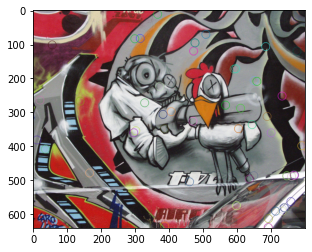

In [234]:
# draw detected keypoints
out = np.copy(image_rgb)
out = cv.drawKeypoints(image_rgb,keypoints,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(out)

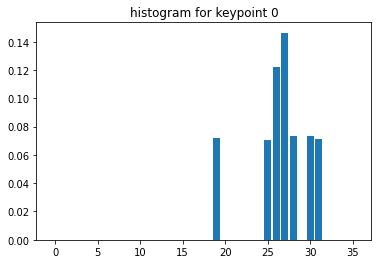

In [235]:
# use Sobel to calculate image gradient
grad_x = cv.Sobel(img_float, cv.CV_32FC1, 1, 0, None, ksize=3)
grad_y = cv.Sobel(img_float, cv.CV_32FC1, 0, 1, None, ksize=3)
# calculate gradient orientation and magnitude for the whole image
img_orientation = np.arctan2(grad_y, grad_x) * 180 / np.pi + 180
img_magnitude = np.sqrt(grad_x**2 + grad_y**2)


def assignOrientation(img_orientation, img_magnitude, keypoints):
    # assign correct orientation for each keypoint
    keypoints_new = []
    (nrows, ncols) = grad_x.shape
    ploted = False
    for kp in keypoints:
        # make sure no index out of bound
        pt = cv.KeyPoint_convert([kp])
        x, y = int(pt[0, 0]), int(pt[0, 1])
        if x >= 1 and y >= 1 and x < ncols - 2 and y < nrows - 2:
            # extra 4x4 region
            orient_window = img_orientation[y - 1 : y + 2, x - 1 : x + 2]
            magnit_window = img_magnitude[y - 1 : y + 2, x - 1 : x + 2]
            magnitude_window = gaussian_blur(magnit_window, sigma)
            histogram = np.zeros((36,))
            for i in range(orient_window.shape[0]):
                for j in range(orient_window.shape[1]):
                    bin = int(orient_window[i, j] // 10) % 36
                    histogram[bin] += magnitude_window[i, j]
            # find the dominant angle
            bin_max = np.argmax(histogram)
            keypoints_new.append(
                cv.KeyPoint(
                    x,
                    y,
                    magnitude_window[1, 1] * 100,
                    (bin_max + 1) * 10.0,
                )
            )
            # display 0th keypoint histogram
            if not ploted:
                plt.figure()
                plt.bar(range(36), histogram)
                plt.title("histogram for keypoint 0")
                ploted = True
    return keypoints_new


keypoints_new = assignOrientation(img_orientation, img_magnitude, keypoints)


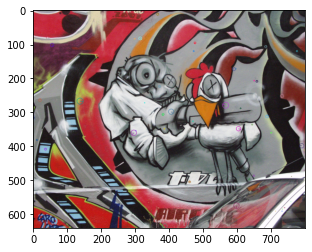

In [236]:
# draw detected keypoints with orientations
out = np.copy(image_rgb)
out = cv.drawKeypoints(image_rgb,keypoints_new,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(out)

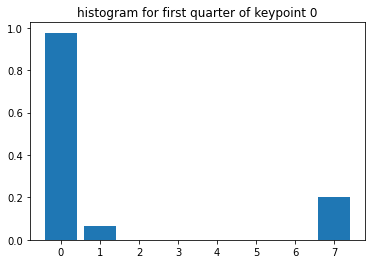

In [237]:

def describeKeypoints(img_orientation, img_magnitude, keypoints):
    # calculate the descriptor matrix for each keypoint
    descriptors = []
    (nrows, ncols) = grad_x.shape
    ploted = False
    for kp in keypoints:
        # make sure no index out of bound
        pt = cv.KeyPoint_convert([kp])
        x, y = int(pt[0, 0]), int(pt[0, 1])
        angle = kp.angle
        desc = []
        if x >= 7 and y >= 7 and x < ncols - 8 and y < nrows - 8:
            # extract 16x16 region
            orient_window = img_orientation[y - 7 : y + 8, x - 7 : x + 8]
            magnit_window = img_magnitude[y - 7 : y + 8, x - 7 : x + 8]
            # loop through 4x4 quater of the window
            for s in range(0,16,4):
                for t in range(0,16,4):
                    orient_subwindow = orient_window[s:s+4,t:t+4]
                    magnit_subwindow = magnit_window[s:s+4,t:t+4]
                    magnit_subwindow = gaussian_blur(magnit_subwindow, sigma)
                    # use small histogram
                    histogram = np.zeros((8,))
                    for i in range(orient_subwindow.shape[0]):
                        for j in range(orient_subwindow.shape[1]):
                            # substract dominant angle to achieve invariance
                            bin = int((orient_subwindow[i, j] - angle) // 45) % 8
                            histogram[bin] += magnit_subwindow[i, j]
                    # normalize histogram
                    norm = np.linalg.norm(histogram)
                    histogram_normal = histogram/norm
                    desc.append(histogram_normal)
            descriptors.append(desc)
            # display 0th keypoint histogram
            if not ploted:
                plt.figure()
                plt.bar(range(8), desc[0])
                plt.title("histogram for first quarter of keypoint 0")
                ploted = True
    return descriptors
    
descriptors = describeKeypoints(img_orientation,img_magnitude,keypoints_new)

In [238]:
# everything put together
def sift(image):
    # preprocess image
    img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    img_float = img_gray.astype(np.float32) / 256

    octaves_DoG = detectExtrema(img_float)
    _, keypoints = locateKeypoints(octaves_DoG)

    # use Sobel to calculate image gradient
    grad_x = cv.Sobel(img_float, cv.CV_32FC1, 1, 0, None, ksize=3)
    grad_y = cv.Sobel(img_float, cv.CV_32FC1, 0, 1, None, ksize=3)
    # calculate gradient orientation and magnitude for the whole image
    img_orientation = np.arctan2(grad_y, grad_x) * 180 / np.pi + 180
    img_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    keypoints_new = assignOrientation(img_orientation, img_magnitude, keypoints)
    descriptors = describeKeypoints(img_orientation, img_magnitude, keypoints_new)

    return keypoints_new, descriptors


def matchDescriptors(desc1, desc2):
    # search for matched keypoint from desciptors of two images
    matches = []
    for i in range(len(desc1)):
        best1 = calcSSD(desc1[i], desc2[0])
        best2 = best1
        best1_idx = 0
        best2_idx = 0
        for j in range(len(desc2)):
            ssd = calcSSD(desc1[i], desc2[j])
            if ssd < best1:
                best2 = best1
                best2_idx = best1_idx
                best1 = ssd
                best1_idx = j
        # ratio test
        if best1 / best2 > 0.8:
            continue
        matches.append(cv.DMatch(i, best1_idx, best1))
    return matches


def calcSSD(arr1, arr2):
    return np.sum((np.array(arr1) - np.array(arr2)) ** 2)


4 4
0 1
0 2
1 1
1 2
2 1
2 2
3 1
3 2
52  keypoints
4 4
0 1
0 2
1 1
1 2
2 1
2 2
3 1
3 2
34  keypoints


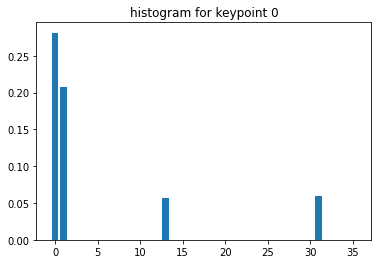

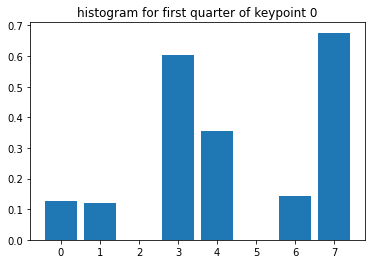

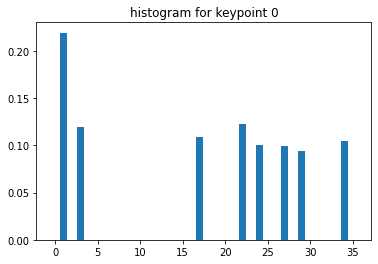

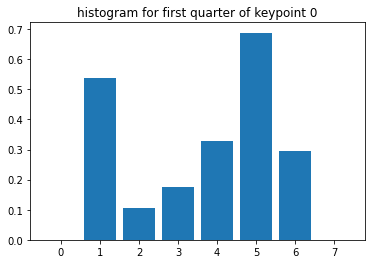

In [239]:
# read the image
img1 = cv.imread("data/contrast1.jpg")
img2 = cv.imread("data/contrast5.jpg")
kp1, desc1 = sift(img1)
kp2, desc2 = sift(img2)


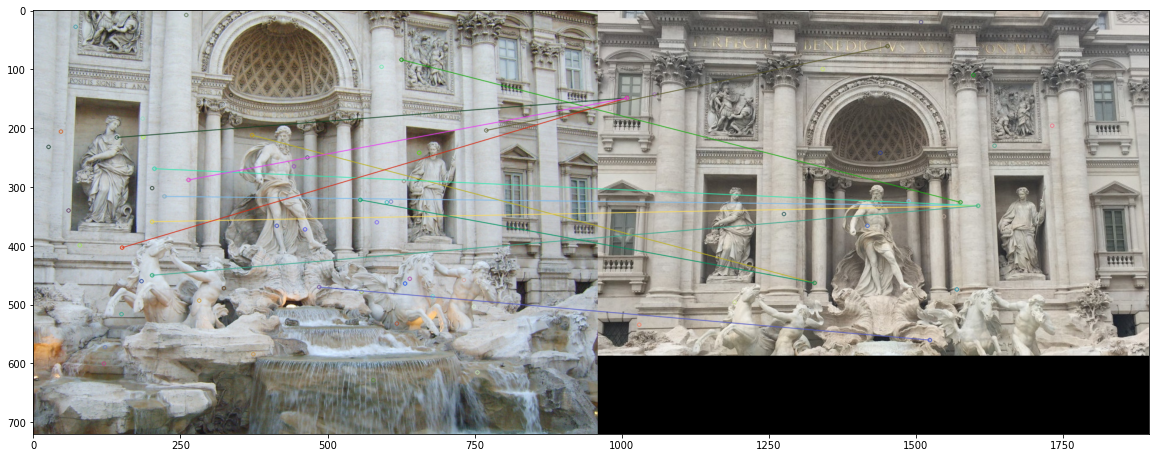

In [240]:
matches = matchDescriptors(desc1, desc2)
# display it
out = np.copy(image_rgb)
img1_rgb = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2_rgb = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
out = cv.drawMatches(img1_rgb, kp1, img2_rgb, kp2, matches, None)
plt.figure(figsize=(20,10))
plt.imshow(out)


# References:
1. D. G. Lowe, "Object recognition from local scale-invariant features," Proceedings of the Seventh IEEE International Conference on Computer Vision, 1999, pp. 1150-1157 vol.2, doi: 10.1109/ICCV.1999.790410.